In [1]:
import nippy
import numpy as np
import pandas as pd

In [104]:
import matplotlib.pyplot as plt

In [105]:
#Load data
d = pd.read_excel('../Data/CleanedData/CAL-VAL_honeAg.xlsx')

In [106]:
d.iloc[:,15:].head()

,1350.155463,1351.397397,1352.641615,1353.888128,1355.136939,1356.388058,1357.641487,1358.897237,1360.155310,1361.415716,...,2510.778668,2515.076906,2519.389892,2523.717689,2528.060387,2532.418049,2536.790767,2541.178605,2545.581654,2549.999982
0,0.105649,0.104276,0.102927,0.101602,0.100541,0.099512,0.098493,0.097632,0.097066,0.096503,...,0.569960,0.572258,0.574513,0.576679,0.578867,0.581080,0.583059,0.584996,0.586952,0.588972
1,0.105379,0.104057,0.102760,0.101484,0.100442,0.099428,0.098424,0.097570,0.096994,0.096420,...,0.566385,0.568417,0.570653,0.573206,0.575785,0.578392,0.581116,0.583891,0.586693,0.589506
2,0.093352,0.092175,0.091019,0.089883,0.088953,0.088049,0.087153,0.086407,0.085939,0.085473,...,0.540407,0.542653,0.544985,0.547437,0.549915,0.552419,0.554704,0.556952,0.559221,0.561459
3,0.093324,0.092238,0.091171,0.090123,0.089242,0.088383,0.087532,0.086802,0.086297,0.085794,...,0.539649,0.541722,0.543852,0.546059,0.548290,0.550544,0.552891,0.555280,0.557692,0.560171
4,0.114227,0.112918,0.111633,0.110371,0.109295,0.108245,0.107205,0.106312,0.105694,0.105079,...,0.552363,0.554114,0.555987,0.558045,0.560124,0.562227,0.564753,0.567404,0.570083,0.572887


In [107]:
train = d[d['data_type']=='calibration']
test = d[d['data_type']=='validation']

train_idx = list(d[d['data_type']=='calibration'].index)
test_idx = list(d[d['data_type']=='validation'].index)

#Build predictors
x_train = train.iloc[:,15:]
xcolnames = x_train.columns
x_test = test.iloc[:,15:]
#Extract targets
y_train = train[['Protein%','Fat%','Starch%']]
y_test = test[['Protein%','Fat%','Starch%']]
ycolnames = y_train.columns

#Extract sample metadata from test set
test_set_metadata = test[['Species','Wet lab_ID','Genotype']]

In [108]:
test_idx[:5]

[6, 7, 12, 13, 60]

In [109]:
data = d.iloc[:,15:]

In [110]:
wl = np.array([int(l) for l in data.columns])

In [111]:
spectra = data.to_numpy().T

In [112]:
def plot_spectra(wl,spectra):
    plt.figure(figsize=(8,9))
    with plt.style.context(('ggplot')):
        plt.plot(wl, spectra)
        plt.title('Original data')

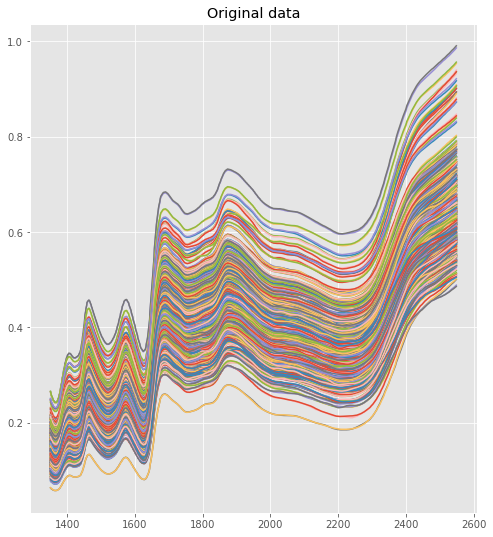

In [113]:
#Plot original data
plot_spectra(wl,spectra)

In [114]:
#Read the protocol configuration file
pipelines = nippy.read_configuration('NIRS/config.ini')

In [115]:
#Generate a list of all possible preprocessing permutation
datasets = nippy.nippy(wl, spectra, pipelines)

Running pipe 1:
{'LSNV': {}, 'MSC': None, 'SAVGOL': {'deriv_order': 0, 'filter_win': 13, 'poly_order': 3}, 'SMOOTH': None, 'SNV': None}

Running pipe 2:
{'LSNV': None, 'MSC': None, 'SAVGOL': None, 'SMOOTH': {'filter_win': 41}, 'SNV': None}

Running pipe 3:
{'LSNV': None, 'MSC': {}, 'SAVGOL': {'deriv_order': 2, 'filter_win': 7, 'poly_order': 3}, 'SMOOTH': None, 'SNV': None}

Running pipe 4:
{'LSNV': None, 'MSC': None, 'SAVGOL': None, 'SMOOTH': {'filter_win': 25}, 'SNV': None}

Running pipe 5:
{'LSNV': None, 'MSC': {}, 'SAVGOL': {'deriv_order': 1, 'filter_win': 13, 'poly_order': 3}, 'SMOOTH': None, 'SNV': None}

Running pipe 6:
{'LSNV': None, 'MSC': None, 'SAVGOL': {'deriv_order': 1, 'filter_win': 7, 'poly_order': 3}, 'SMOOTH': None, 'SNV': None}

Running pipe 7:
{'LSNV': {}, 'MSC': None, 'SAVGOL': {'deriv_order': 2, 'filter_win': 13, 'poly_order': 3}, 'SMOOTH': None, 'SNV': None}

Running pipe 8:
{'LSNV': None, 'MSC': {}, 'SAVGOL': {'deriv_order': 1, 'filter_win': 11, 'poly_order': 3}, 

In [116]:
len(datasets)

52

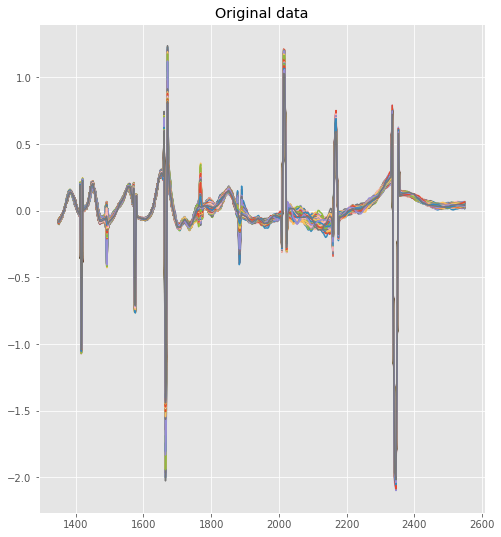

In [135]:
plot_spectra(datasets[30][0],datasets[30][1])

In [118]:
len(pipelines)

52

In [119]:
#AutoML with H2O
import h2o

In [136]:
#Prepare data for autoMl model
dataset = datasets[30][1]
x_cols = datasets[30][0]

In [137]:
xtrain = dataset[:,train_idx].T
xtest = dataset[:,test_idx].T

In [138]:
#Convert to dataframes
xtrain = pd.DataFrame(xtrain,columns=x_cols)

In [139]:
train.shape

(632, 516)

In [140]:
xtest = pd.DataFrame(xtest,columns=x_cols)

In [141]:
xtest.shape

(184, 513)

In [142]:
from sklearn.preprocessing import StandardScaler

In [143]:
xscaler = StandardScaler()
xtrain = xscaler.fit_transform(xtrain)
xtest = xscaler.transform(xtest)

In [144]:
yscaler = StandardScaler()
ytrain = yscaler.fit_transform(y_train)
ytest = yscaler.transform(y_test)

In [145]:
#Convert to dataframes
xtrain = pd.DataFrame(xtrain,columns=x_cols)
xtest = pd.DataFrame(xtest,columns=x_cols)
ytrain = pd.DataFrame(ytrain,columns=ycolnames)
ytest = pd.DataFrame(ytest,columns=ycolnames)

In [146]:
train = pd.concat([ytrain,xtrain],axis=1)
test = pd.concat([ytest,xtest],axis=1)

In [147]:
#Run the cluster
h2o.init(nthreads=2)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 hours 27 mins
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,"14 days, 7 hours and 16 minutes"
H2O_cluster_name:,H2O_from_python_DELL_8w8jwk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.924 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


In [148]:
#Convert to h2o frames
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [155]:
from h2o.automl import H2OAutoML

#instanciation
aml = H2OAutoML(seed=100, nfolds=5, max_runtime_secs=180)

In [156]:
aml.train(x=train.columns[3:],y='Starch%',training_frame=train)

AutoML progress: |█
22:53:54.161: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████| 100%


In [151]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20201012_224707,0.117288,0.342474,0.117288,0.256004,nan
StackedEnsemble_AllModels_AutoML_20201012_224707,0.117366,0.342588,0.117366,0.25643,nan
GBM_grid__1_AutoML_20201012_224707_model_1,0.16195,0.40243,0.16195,0.316789,nan
XRT_1_AutoML_20201012_224707,0.2689,0.518556,0.2689,0.336621,nan
DRF_1_AutoML_20201012_224707,0.315223,0.561447,0.315223,0.367067,nan
DeepLearning_1_AutoML_20201012_224707,0.460271,0.678432,0.460271,0.545763,nan
GLM_1_AutoML_20201012_224707,0.500584,0.707519,0.500584,0.555233,nan
GBM_5_AutoML_20201012_224707,0.576751,0.759441,0.576751,0.592326,nan
GBM_2_AutoML_20201012_224707,0.644706,0.802936,0.644706,0.620765,nan
GBM_3_AutoML_20201012_224707,0.716079,0.846214,0.716079,0.660658,nan


In [157]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20201012_225354

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.04041286191179882
RMSE: 0.20102950507773434
MAE: 0.15105845885159983
RMSLE: NaN
R^2: 0.9595871382127283
Mean Residual Deviance: 0.04041286191179882
Null degrees of freedom: 631
Residual degrees of freedom: 625
Null deviance: 632.0000019474298
Residual deviance: 25.54092872825685
AIC: -218.3014321234386

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.39131913819164765
RMSE: 0.625555064076415
MAE: 0.478692108004266
RMSLE: NaN
R^2: 0.6086808630141538
Mean Residual Deviance: 0.39131913819164765
Null degrees of freedom: 631
Residual degrees of freedom: 626
Null deviance: 632.9856196121264
Residual deviance: 247.31369533712132
AIC: 1214.575782012284


In [165]:
import sys
from io import BytesIO
from contextlib import contextmanager
 
@contextmanager
def capture_ouput(stdout_to=None, stderr_to=None):
    try:
 
        stdout, stderr = sys.stdout, sys.stderr
        sys.stdout = c1 = stdout_to or BytesIO()
        sys.stderr = c2 = stderr_to or BytesIO()
        yield c1, c2
 
    finally:
 
        sys.stdout = stdout
        sys.stderr = stderr
 
        try:
            c1.flush()
            c1.seek(0)
        except (ValueError, IOError):
            pass
 
        try:
            c2.flush()
            c2.seek(0)
        except (ValueError, IOError):
            pass

In [ ]:
import sys
log = open('../Results/log.txt', 'w')
sys.stdout = log # hop, on hijack la sortie standard
print(aml.leader)
log.close()

In [ ]:
h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')

In [162]:
aml.leader.cross_validation_metrics_summary()

No cross-validation metrics summary for this model


In [158]:
#Model performance on test set
print(aml.leader.model_performance(test))


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.5685438315554289
RMSE: 0.7540184557127424
MAE: 0.5960917524758651
RMSLE: NaN
R^2: 0.48952102542845344
Mean Residual Deviance: 0.5685438315554289
Null degrees of freedom: 183
Residual degrees of freedom: 177
Null deviance: 206.919023293206
Residual deviance: 104.6120650061989
AIC: 434.2688364333011



In [86]:
type(aml.leader.model_performance(test))

h2o.model.metrics_base.H2ORegressionModelMetrics

In [95]:
h2o.cluster().shutdown()

H2O session _sid_b952 closed.
